In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
sys.path.append('..')

from rxnframe import RXN_frame
import json

In [2]:
# Multi step reaction indexes from https://www.science.org/doi/10.1126/science.abo0058

double_step_procs = {
    1: ["0034", "0010"],
    2: ["0035", "0010"],
    3: ["0078", "0037"],
    4: ["0037", "0012"],
    5: ["0075", "0004"],
    6: ["0004", "0005"],
    7: ["0056", "0022"],
    8: ["0056", "0023",],
    9: ["0038", "0079"],
    10: ["0040", "0042"],
    11: ["0043", "0044"],
    12: ["0044", "0045"],
    13: ["0046", "0047"],
}

triple_step_procs = {
    1: ["0034", "0035", "0010"],
    2: ["0078", "0037", "0012"],
    3: ["0075", "0004", "0005"],
    4: ["0043", "0044", "0045"]
}

In [3]:
with open("../data/reaction_summary.json", "r") as f:
    summary = json.load(f)

In [8]:
def get_rxn_details(run_id_suffix, summary_data):
    # run_id_suffix is like "0034"
    # summary RXN_ID is like "CHEMIFY-0034"
    target_id = f"CHEMIFY-{run_id_suffix}"
    for entry in summary_data:
        if entry.get("RXN_ID") == target_id:
            return entry.get("REACTION"), entry.get("yield") if entry.get("yield") != -1 else None, entry.get("SCALE")
    return None, None

rows = []
sorted_summary = sorted(summary, key=lambda x: x.get('RXN_ID', ''))


for entry in sorted_summary:
    rxn_id = entry.get('RXN_ID')
    rows.append({
        "ID": rxn_id,
        "Step 1": entry.get("REACTION"),
        "Step 2": None,
        "Step 3": None,
        "Yield": entry.get("yield") if entry.get("yield") != -1 else None,
        "Scale": entry.get("SCALE")
    })

for idx, steps in double_step_procs.items():
    s1, y1, scale1 = get_rxn_details(steps[0], summary)
    s2, y2, scale2 = get_rxn_details(steps[1], summary)
    
    rows.append({
        "ID": f"TwoStep-{idx} ({steps[0]}+{steps[1]})", 
        "Step 1": s1,
        "Step 2": s2,
        "Step 3": None,
        "Yield": f"{y1}, {y2}",
        "Scale": f"{scale1}, {scale2}"
    })

for idx, steps in triple_step_procs.items():
    s1, y1, scale1 = get_rxn_details(steps[0], summary)
    s2, y2, scale2 = get_rxn_details(steps[1], summary)
    s3, y3, scale3 = get_rxn_details(steps[2], summary)
    
    rows.append({
        "ID": f"ThreeStep-{idx} ({steps[0]}+{steps[1]}+{steps[2]})",
        "Step 1": s1,
        "Step 2": s2,
        "Step 3": s3,
        "Yield": f"{y1}, {y2}, {y3}",
        "Scale": f"{scale1}, {scale2}, {scale3}"
    })

df_all = pd.DataFrame(rows)


Number of rows: 117

-----

WeasyPrint could not import some external libraries. Please carefully follow the installation steps before reporting an issue:
https://doc.courtbouillon.org/weasyprint/stable/first_steps.html#installation
https://doc.courtbouillon.org/weasyprint/stable/first_steps.html#troubleshooting 

-----

Could not save PDF to reaction_display.pdf: cannot load library 'libgobject-2.0-0': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libgobject-2.0-0'


,ID,Step 1,Step 2,Step 3,Yield,Scale
1,CHEMIFY-0001,,,,98 %,8.8 mmol
2,CHEMIFY-0002,,,,56 %,20.0 mmol
3,CHEMIFY-0004,,,,84 %,10.0 mmol
4,CHEMIFY-0005,,,,37 %,13.0 mmol
5,CHEMIFY-0006,,,,65 %,20.0 mmol
6,CHEMIFY-0010,,,,43 %,10.0 mmol
7,CHEMIFY-0011,,,,94 %,5.0 mmol
8,CHEMIFY-0012,,,,92 %,2.0 mmol
9,CHEMIFY-0013,,,,62 %,15.0 mmol
10,CHEMIFY-0014,,,,60 %,25.1 mmol

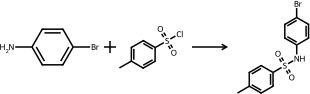
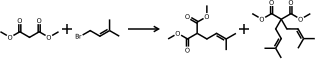
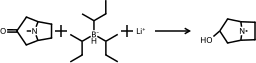
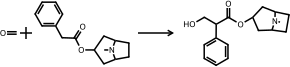
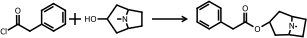
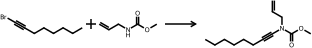
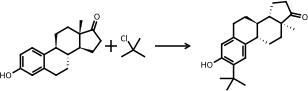
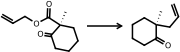
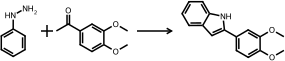
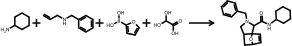
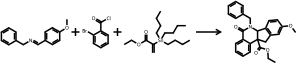
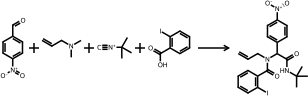
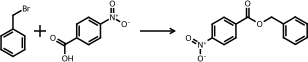
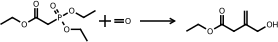
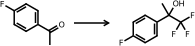
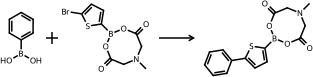
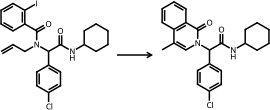
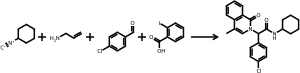
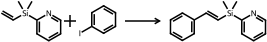
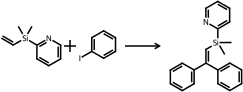
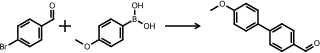
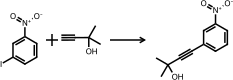
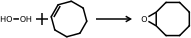
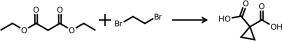
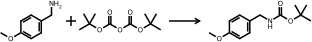
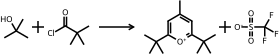
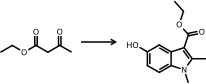
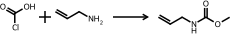
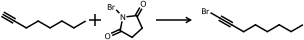
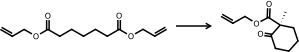
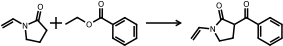
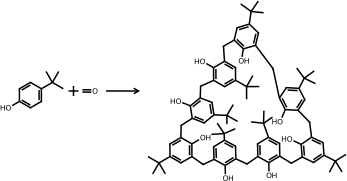
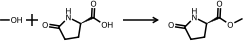
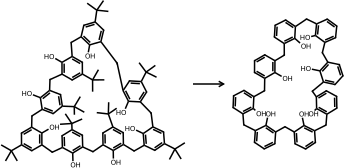
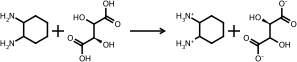
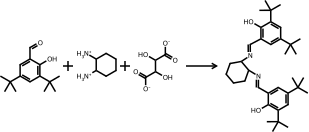
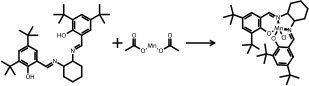
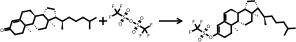
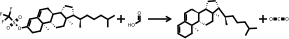
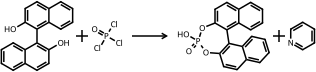
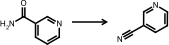
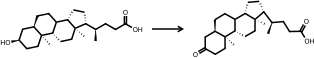
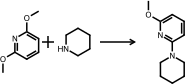
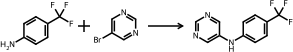
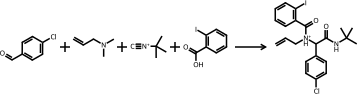
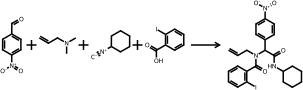
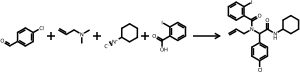
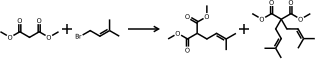
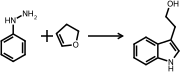
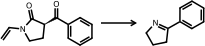
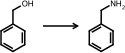
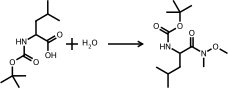
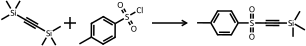
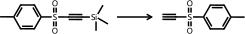
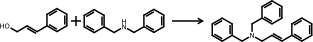
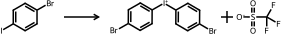
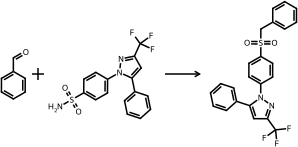
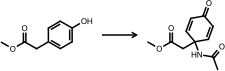
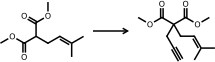
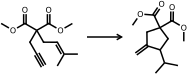
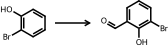
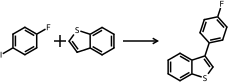
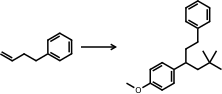
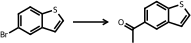
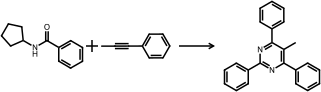
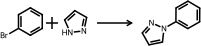
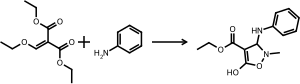
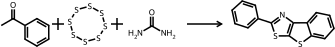
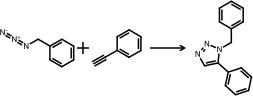
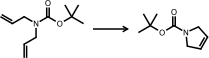
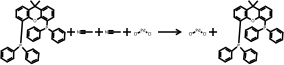
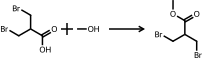
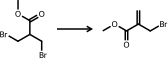
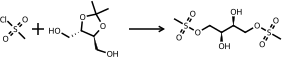
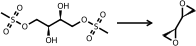
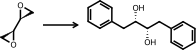
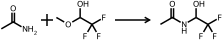
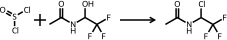
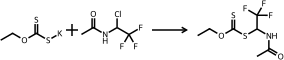
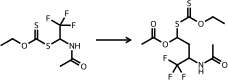
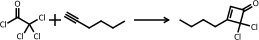
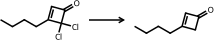
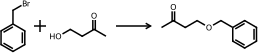
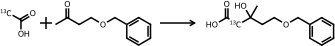
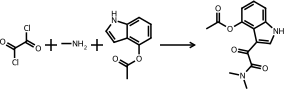
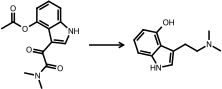
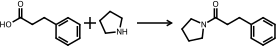
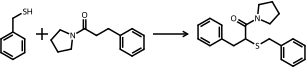
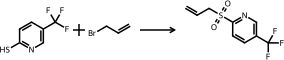
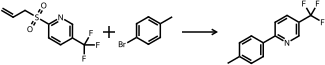
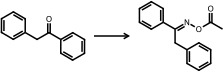
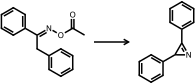
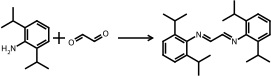
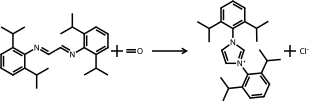
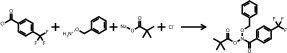
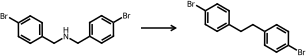
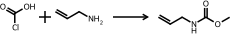
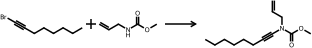
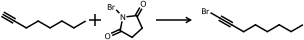
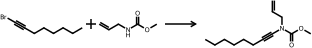
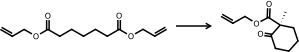
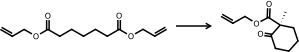
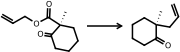
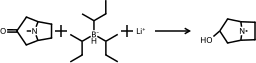
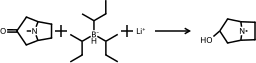
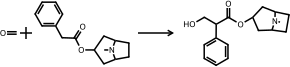
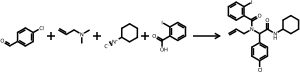
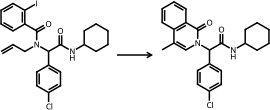
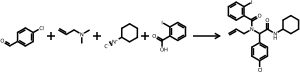
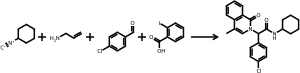
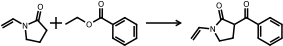
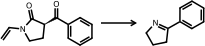
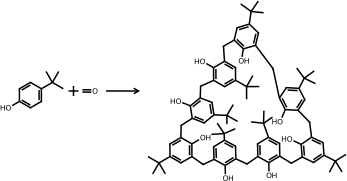
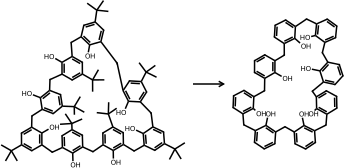
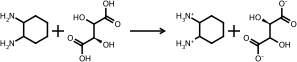
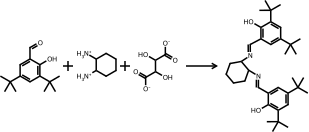
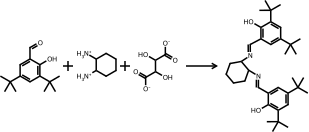
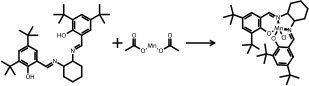
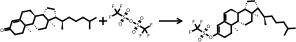
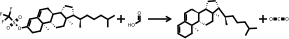
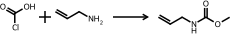
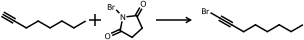
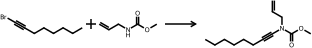
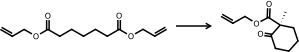
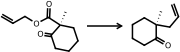
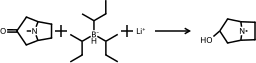
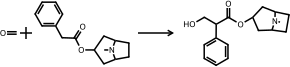
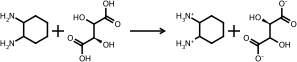
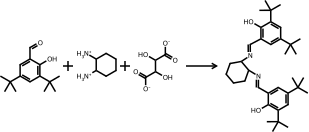
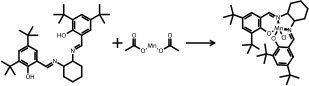

In [9]:
rxn_cols = ["Step 1", "Step 2", "Step 3"]
frame = RXN_frame(df_all, mol_cols=[], rxn_cols=rxn_cols)
frame.display_rxns("reaction_display.pdf")